# Gradient Boosting Classifier Model - with Stratification
---
The model in this notebook was strongly influenced by Natural Chan.  The following gradient boosted classifier will be used in an ordinal regression dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# from kappa_score import qwkappa

In [3]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_output_path = os.path.join(os.getcwd(),'grad boost output')
os.makedirs(gb_output_path, exist_ok = True)

In [4]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
quality_rating = list(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify= quality_rating,
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Investigate Gradient Boosted Model Parameters
Using the parameters from the best model search, investigate stratify and AUC ROC

In [5]:
# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200], # number of weak learning trees
    'learning_rate': [0.01, 0.1, 0.2], # control possibility of overfitting.
    # Strong interaction with n_estimators: smaller learning rates require more n_estimators
    'max_depth': [3, 5, 7] #  size of each tree
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation, mark timer start
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=skfold, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.559 total time=   1.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.562 total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.574 total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.596 total time=   0.9s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.567 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.571 total time=   1.7s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.568 total time=   1.7s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.559 total time=   1.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.596 total time=   1.7s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.564 to

In [6]:
# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1 = f1_score(y_val, y_pred, average= 'weighted')
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

print(f"First model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb.n_estimators}")
print(f"Best Learning Rate: {best_gb.learning_rate}")
print(f"Best Max Depth: {best_gb.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}")

First model scores with stratify and skf:
-------------------
Best Estimators: 200
Best Learning Rate: 0.01
Best Max Depth: 3
Accuracy: 0.59
F1: 0.58
Precision: 0.57
Recall: 0.59
Cohen Kappa Score, quadratic weighted: 0.5300


In [7]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_2 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_2 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_2 = time.time()
grid_search_2 = GridSearchCV(model_2, param_grid_2, cv=skfold, verbose=3)
grid_search_2.fit(X_train, y_train)

# Get the best model from grid search
best_gb_2 = grid_search_2.best_estimator_
grid_search_time_2 = time.time()

# Make predictions on the test data using the best model
y_pred_2 = best_gb_2.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_2 = time.time()
grid_time_2 = grid_search_time_2 - start_time_2
pred_time_2 = end_time_2 - grid_search_time_2
tot_time_2 = end_time_2 - start_time_2

print(f"Time to complete Grid Search: {grid_time_2:.6f} seconds")
print(f"Time to complete prediction: {pred_time_2:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_2:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.547 total time=   3.4s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.550 total time=   3.3s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.562 total time=   3.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.571 total time=   3.2s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.546 total time=   3.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.559 total time=   6.4s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.556 total time=   6.3s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.568 total time=   6.6s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.593 total time=   6.5s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=400;,

In [8]:
# Calculate metrics
accuracy_2 = accuracy_score(y_val, y_pred_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_2 = f1_score(y_val, y_pred_2, average= 'weighted')
precision_2 = precision_score(y_val, y_pred_2, average= 'weighted')
recall_2 = recall_score(y_val, y_pred_2, average= 'weighted')
kappa_2 = cohen_kappa_score(y_val, y_pred_2, weights='quadratic')

print(f"Second model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb_2.n_estimators}")
print(f"Best Learning Rate: {best_gb_2.learning_rate}")
print(f"Best Max Depth: {best_gb_2.max_depth}")
print(f"Accuracy: {accuracy_2:.2f}")
print(f"F1: {f1_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa_2:.4f}")

Second model scores with stratify and skf:
-------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 3
Accuracy: 0.60
F1: 0.59
Precision: 0.58
Recall: 0.60
Cohen Kappa Score, quadratic weighted: 0.5284


In [9]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_3 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_3 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [2, 3, 5]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_3 = time.time()
grid_search_3 = GridSearchCV(model_3, param_grid_3, cv=skfold, verbose=3)
grid_search_3.fit(X_train, y_train)

# Get the best model from grid search
best_gb_3 = grid_search_3.best_estimator_
grid_search_time_3 = time.time()

# Make predictions on the test data using the best model
y_pred_3 = best_gb_3.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_3 = time.time()
grid_time_3 = grid_search_time_3 - start_time_3
pred_time_3 = end_time_3 - grid_search_time_3
tot_time_3 = end_time_3 - start_time_3

print(f"Time to complete Grid Search: {grid_time_3:.6f} seconds")
print(f"Time to complete prediction: {pred_time_3:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_3:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.544 total time=   2.7s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.541 total time=   2.9s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.550 total time=   2.8s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.584 total time=   2.7s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.540 total time=   2.7s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.541 total time=   5.3s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.553 total time=   5.5s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.553 total time=   5.3s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.584 total time=   5.0s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=400;,

In [10]:
# Calculate metrics
accuracy_3 = accuracy_score(y_val, y_pred_3)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_3 = f1_score(y_val, y_pred_3, average= 'weighted')
precision_3 = precision_score(y_val, y_pred_3, average= 'weighted')
recall_3 = recall_score(y_val, y_pred_3, average= 'weighted')
kappa_3 = cohen_kappa_score(y_val, y_pred_3, weights='quadratic')

print(f"Third model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb_3.n_estimators}")
print(f"Best Learning Rate: {best_gb_3.learning_rate}")
print(f"Best Max Depth: {best_gb_3.max_depth}")
print(f"Accuracy: {accuracy_3:.2f}")
print(f"F1: {f1_3:.2f}")
print(f"Precision: {precision_3:.2f}")
print(f"Recall: {recall_3:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa_3:.4f}")

Third model scores with stratify and skf:
-------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 3
Accuracy: 0.60
F1: 0.59
Precision: 0.58
Recall: 0.60
Cohen Kappa Score, quadratic weighted: 0.5284


In [11]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_4 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_4 = {
    'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 7, 9]
}

# Use stratified k-fold cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
start_time_4 = time.time()
grid_search_4 = GridSearchCV(model_4, param_grid_4, cv=skfold, verbose=3)
grid_search_4.fit(X_train, y_train)

# Get the best model from grid search
best_gb_4 = grid_search_4.best_estimator_
grid_search_time_4 = time.time()

# Make predictions on the test data using the best model
y_pred_4 = best_gb_4.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_4 = time.time()
grid_time_4 = grid_search_time_4 - start_time_4
pred_time_4 = end_time_4 - grid_search_time_4
tot_time_4 = end_time_4 - start_time_4

print(f"Time to complete Grid Search: {grid_time_4:.6f} seconds")
print(f"Time to complete prediction: {pred_time_4:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_4:.6f} seconds")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.410 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.409 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.410 total time=   0.3s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0

In [12]:
# Calculate metrics
accuracy_4 = accuracy_score(y_val, y_pred_4)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_4 = f1_score(y_val, y_pred_4, average= 'weighted')
precision_4 = precision_score(y_val, y_pred_4, average= 'weighted')
recall_4 = recall_score(y_val, y_pred_4, average= 'weighted')
kappa_4 = cohen_kappa_score(y_val, y_pred_4, weights='quadratic')

print(f"Fourth model scores with stratify and skf:")
print("-------------------")
print(f"Best Estimators: {best_gb_4.n_estimators}")
print(f"Best Learning Rate: {best_gb_4.learning_rate}")
print(f"Best Max Depth: {best_gb_4.max_depth}")
print(f"Accuracy: {accuracy_4:.2f}")
print(f"F1: {f1_4:.2f}")
print(f"Precision: {precision_4:.2f}")
print(f"Recall: {recall_4:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa_4:.4f}")

Fourth model scores with stratify and skf:
-------------------
Best Estimators: 30
Best Learning Rate: 0.05
Best Max Depth: 2
Accuracy: 0.62
F1: 0.60
Precision: 0.60
Recall: 0.62
Cohen Kappa Score, quadratic weighted: 0.5528


# Classification Reports

In [13]:
print("--------------------------------------------------------")

print(f"Best Hyperparameters From the First Round Grad Boost Model Search with stratify and skf")
print(f"     Learning Rate =   {best_gb.learning_rate}")
print(f"     Number of Trees = {best_gb.n_estimators}")
print(f"     Max Tree Depth =  {best_gb.max_depth}")
print()
print("--------------------------------------------------------")
print(f"First Round Grad Boosted Model Classification Report stratify and skf")
print(classification_report(y_val,y_pred))
print()
print("--------------------------------------------------------")
print()
print(f"First Round with stratify and skf Grad Boosted Quadratic Weighted Kappa Score: {kappa:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the First Round Grad Boost Model Search with stratify and skf
     Learning Rate =   0.01
     Number of Trees = 200
     Max Tree Depth =  3

--------------------------------------------------------
First Round Grad Boosted Model Classification Report stratify and skf
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.72      0.72      0.72       168
           6       0.52      0.64      0.57       156
           7       0.49      0.36      0.41        67
           8       0.00      0.00      0.00         8

    accuracy                           0.59       412
   macro avg       0.29      0.29      0.28       412
weighted avg       0.57      0.59      0.58       412


--------------------------------------------------------

First Round with stratify and skf Grad Booste

In [14]:
print("--------------------------------------------------------")

print(f"Best Hyperparameters From the Second Round Grad Boost Model Search with stratify and skf")
print(f"     Learning Rate =   {best_gb_2.learning_rate}")
print(f"     Number of Trees = {best_gb_2.n_estimators}")
print(f"     Max Tree Depth =  {best_gb_2.max_depth}")
print()
print("--------------------------------------------------------")
print(f"Second Round Grad Boosted Model Classification Report with stratify and skf")
print(classification_report(y_val,y_pred_2))
print()
print("--------------------------------------------------------")
print()
print(f"Second Round Grad Boosted with stratify and skf Quadratic Weighted Kappa Score: {kappa_2:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the Second Round Grad Boost Model Search with stratify and skf
     Learning Rate =   0.01
     Number of Trees = 400
     Max Tree Depth =  3

--------------------------------------------------------
Second Round Grad Boosted Model Classification Report with stratify and skf
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.70      0.71      0.71       168
           6       0.54      0.65      0.59       156
           7       0.52      0.40      0.45        67
           8       0.00      0.00      0.00         8

    accuracy                           0.60       412
   macro avg       0.29      0.29      0.29       412
weighted avg       0.58      0.60      0.59       412


--------------------------------------------------------

Second Round Grad Boosted with stratif

In [15]:
print("--------------------------------------------------------")

print(f"Best Hyperparameters From the Third Round Grad Boost Model Search with stratify and skf")
print(f"     Learning Rate =   {best_gb_3.learning_rate}")
print(f"     Number of Trees = {best_gb_3.n_estimators}")
print(f"     Max Tree Depth =  {best_gb_3.max_depth}")
print()
print("--------------------------------------------------------")
print(f"Third Round Grad Boosted Model Classification Report with stratify and  skf")
print(classification_report(y_val,y_pred_3))
print()
print("--------------------------------------------------------")
print()
print(f"Third Round Grad Boosted with stratify and skf Quadratic Weighted Kappa Score: {kappa_3:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the Third Round Grad Boost Model Search with stratify and skf
     Learning Rate =   0.01
     Number of Trees = 400
     Max Tree Depth =  3

--------------------------------------------------------
Third Round Grad Boosted Model Classification Report with stratify and  skf
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.70      0.71      0.71       168
           6       0.54      0.65      0.59       156
           7       0.52      0.40      0.45        67
           8       0.00      0.00      0.00         8

    accuracy                           0.60       412
   macro avg       0.29      0.29      0.29       412
weighted avg       0.58      0.60      0.59       412


--------------------------------------------------------

Third Round Grad Boosted with stratify 

In [16]:
print("--------------------------------------------------------")

print(f"Best Hyperparameters From the Fourth Round Grad Boost Model Search with stratify and skf")
print(f"     Learning Rate =   {best_gb_4.learning_rate}")
print(f"     Number of Trees = {best_gb_4.n_estimators}")
print(f"     Max Tree Depth =  {best_gb_4.max_depth}")
print()
print("--------------------------------------------------------")
print(f"Fourth Round Grad Boosted Model Classification Report with stratifyand skf")
print(classification_report(y_val,y_pred_4))
print()
print("--------------------------------------------------------")
print()
print(f"Forth Round Grad Boosted with stratifyand skf Quadratic Weighted Kappa Score: {kappa_4:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the Fourth Round Grad Boost Model Search with stratify and skf
     Learning Rate =   0.05
     Number of Trees = 30
     Max Tree Depth =  2

--------------------------------------------------------
Fourth Round Grad Boosted Model Classification Report with stratifyand skf
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.71      0.72      0.72       168
           6       0.55      0.69      0.61       156
           7       0.58      0.42      0.49        67
           8       0.00      0.00      0.00         8

    accuracy                           0.62       412
   macro avg       0.31      0.30      0.30       412
weighted avg       0.60      0.62      0.60       412


--------------------------------------------------------

Forth Round Grad Boosted with stratifyan

# Confusion Matrix

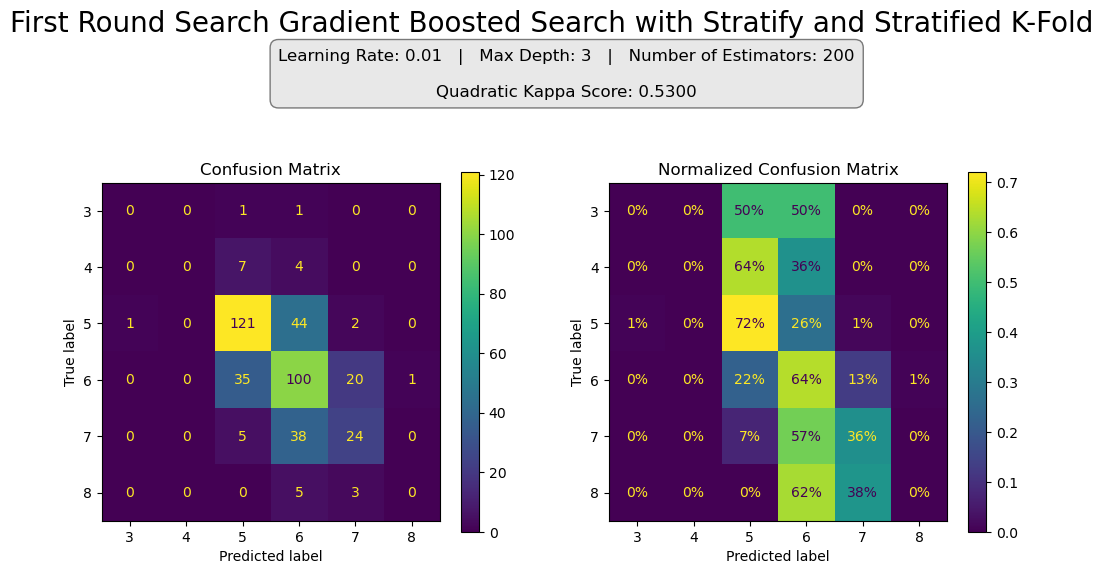

In [21]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs=  f"Learning Rate: {best_gb.learning_rate}   |   Max Depth: {best_gb.max_depth}   |   Number of Estimators: {best_gb.n_estimators}\n\nQuadratic Kappa Score: {kappa:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("First Round Search Gradient Boosted Search with Stratify and Stratified K-Fold", fontsize=20)

# Save and show the figure
output_filename = f"{gb_output_path}/gb_1st_model_kappa={kappa:.4f}_stratify_skf_confusion_matrix.png"
plt.savefig(output_filename)
plt.show()

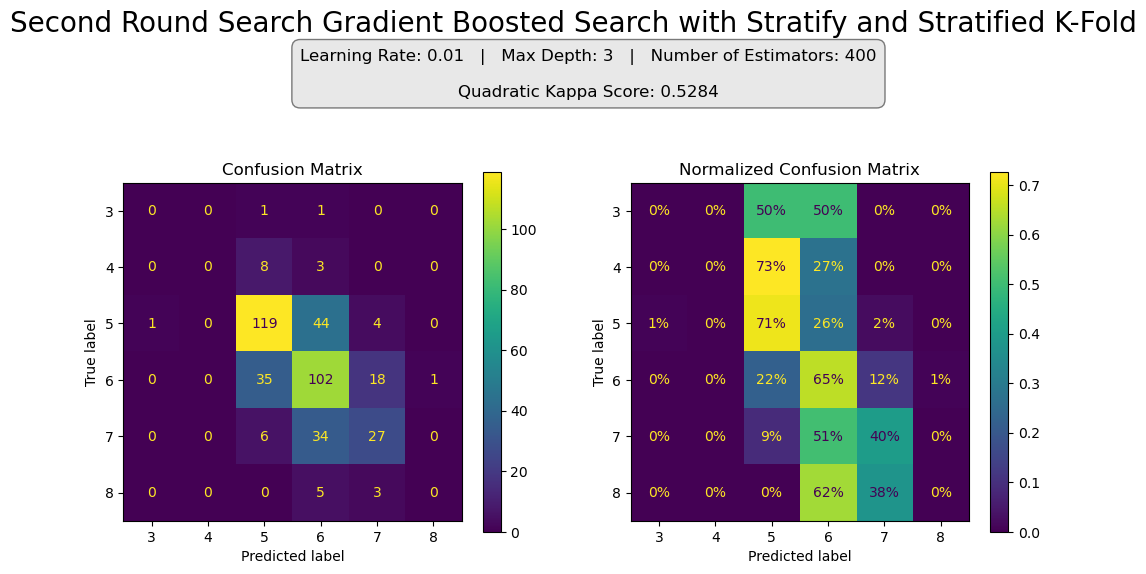

In [22]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs =  f"Learning Rate: {best_gb_2.learning_rate}   |   Max Depth: {best_gb_2.max_depth}   |   Number of Estimators: {best_gb_2.n_estimators}\n\nQuadratic Kappa Score: {kappa_2:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("Second Round Search Gradient Boosted Search with Stratify and Stratified K-Fold", fontsize=20)

# Save and show the figure
output_filename = f"{gb_output_path}/gb_2nd_model_kappa={kappa_2:.4f}_stratify_skf_confusion_matrix.png"
plt.savefig(output_filename)
plt.show()

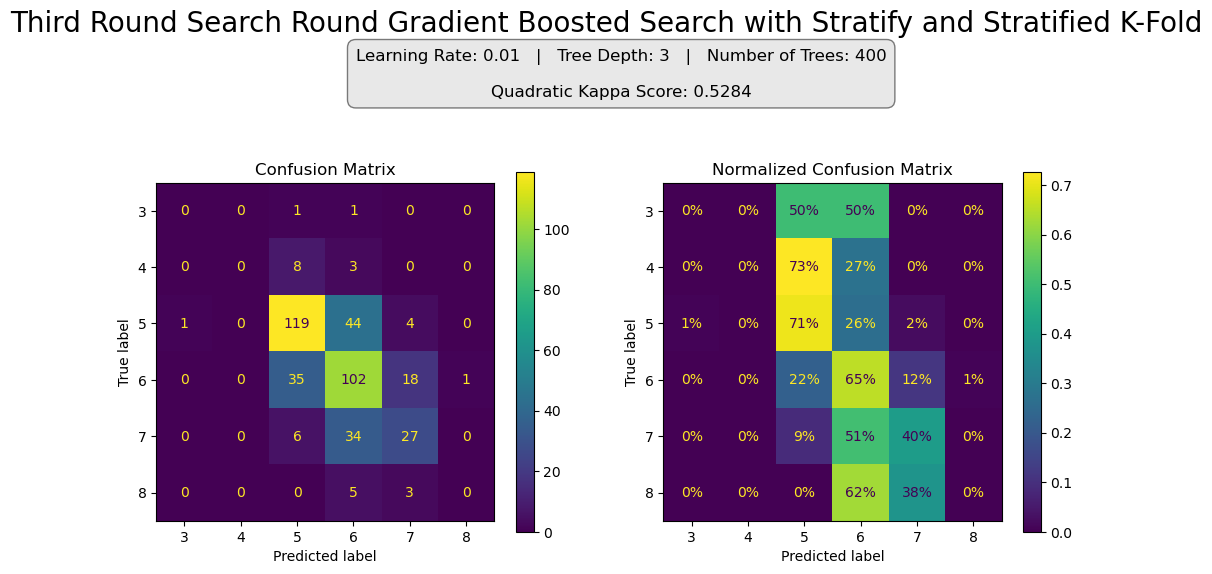

In [23]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs =  f"Learning Rate: {best_gb_3.learning_rate}   |   Tree Depth: {best_gb_3.max_depth}   |   Number of Trees: {best_gb_3.n_estimators}\n\nQuadratic Kappa Score: {kappa_3:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("Third Round Search Round Gradient Boosted Search with Stratify and Stratified K-Fold", fontsize=20)

# Save and show the figure
output_filename = f"{gb_output_path}/gb_3rd_model_kappa={kappa_3:.4f}_stratify_skf_confusion_matrix.png"
plt.savefig(output_filename)
plt.show()

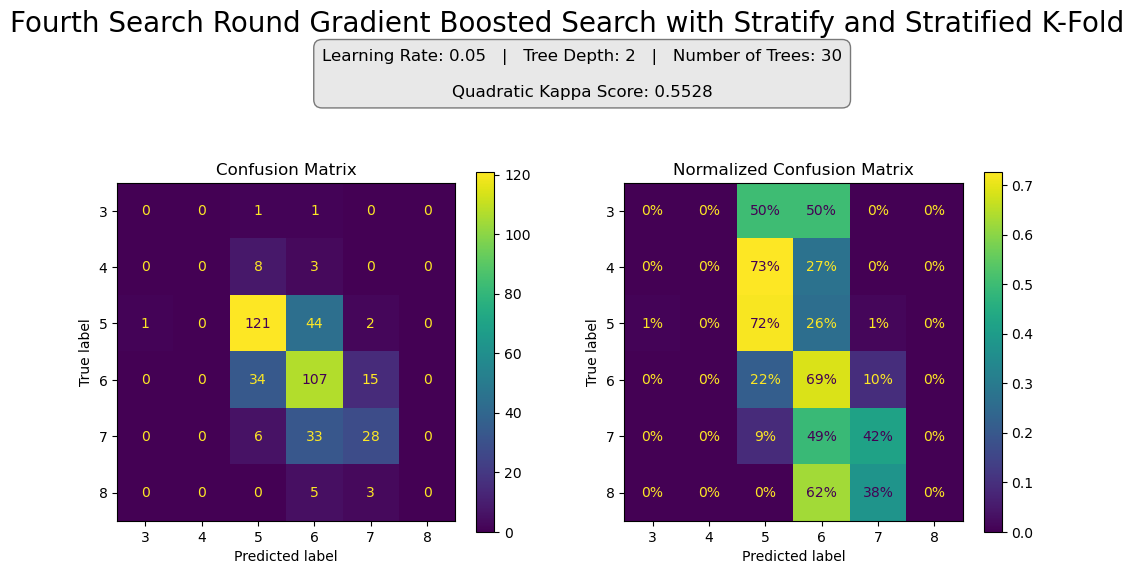

In [25]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs =  f"Learning Rate: {best_gb_4.learning_rate}   |   Tree Depth: {best_gb_4.max_depth}   |   Number of Trees: {best_gb_4.n_estimators}\n\nQuadratic Kappa Score: {kappa_4:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("Fourth Search Round Gradient Boosted Search with Stratify and Stratified K-Fold", fontsize=20)

# Save and show the figure
output_filename = f"{gb_output_path}/gb_4th_model_kappa={kappa_4:.4f}_stratify_skf_confusion_matrix.png"
plt.savefig(output_filename)
plt.show()